In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

# Import relevant libraries
import numpy as np
from numpy import asarray
from PIL import Image
import os

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.losses import BinaryCrossentropy
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

# Training Images


In [2]:
directory = 'faces'
ls = []
label_ls = []
i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk("faces"))
print("len faces: ",len(files))
if int(len(files)/1000) > 0:
    interval = int(len(files)/1000)
for filename in os.listdir(directory):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(directory + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(0)
print("number of examples faces: ", j)

directory = 'no_faces'
i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk("no_faces"))
print("\nlen no_faces: ",len(files))
if int(len(files)/1000) > 0:
    interval = int(len(files)/1000)
for filename in os.listdir(directory):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(directory + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(1)
print("number of examples no_faces: ", j)

imgs_train = np.array(ls, dtype='uint8')
label_train = np.array([label_ls])

len faces:  105
number of examples faces:  105

len no_faces:  134
number of examples no_faces:  134


# Testing images

In [3]:
directory = 'faces_test'
ls = []
label_ls = []
i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk("faces_test"))
print("len faces_test: ",len(files))
if int(len(files)/1000) > 0:
    interval = int(len(files)/1000)
for filename in os.listdir(directory):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(directory + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(0)
print("number of examples faces_test: ", j)

directory = 'no_faces_test'
i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk("no_faces_test"))
print("\nlen no_faces_test: ",len(files))
if int(len(files)/1000) > 0:
    interval = int(len(files)/1000)
for filename in os.listdir(directory):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(directory + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(1)
print("number of examples no_faces_test: ", j)

imgs_test = np.array(ls, dtype='uint8')
label_test = np.array([label_ls])

len faces_test:  1
number of examples faces_test:  1

len no_faces_test:  1
number of examples no_faces_test:  1


In [4]:
# Normalize image vectors
imgs_train_norm = imgs_train / 255.
imgs_test_norm = imgs_test / 255.

# Reshape
label_train_T = label_train.T
label_test_T = label_test.T

print ("Number of training examples = " + str(imgs_train_norm.shape[0]))
print ("Number of testing examples = " + str(imgs_test_norm.shape[0]))
print ("Images train shape: " + str(imgs_train_norm.shape))
print ("Labels train shape: " + str(label_train_T.shape))
print ("Images test shape: " + str(imgs_test_norm.shape))
print ("Labels test shape: " + str(label_test_T.shape))

Number of training examples = 239
Number of testing examples = 2
Images train shape: (239, 256, 256, 3)
Labels train shape: (239, 1)
Images test shape: (2, 256, 256, 3)
Labels test shape: (2, 1)


In [5]:
def FaceDetectionModel(input_shape):
    """
    Implementation of the FaceDetectionModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Use the suggested model in the text above to get started, and run through the whole
    # exercise once. Then come back and add more BLOCKS. 
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)
    
    # BLOCK 1: CONV -> BN -> RELU -> MAXP
    num_filters = 32
    kernel_size = (7, 7)
    stride = (1, 1)
    X = Conv2D(num_filters, kernel_size, strides = stride, name = 'conv0')(X)

    # BLOCK 2: CONV -> BN -> RELU -> MAXP
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
        
    # BLOCK 3: CONV -> BN -> RELU -> MAXP
    X = Activation('relu')(X)
    
    # BLOCK 4: CONV -> BN -> RELU -> MAXP
    max_pool_size = (2, 2)
    X = MaxPooling2D(max_pool_size, name='max_pool')(X)
       
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model.
    model = Model(inputs = X_input, outputs = X, name='FaceDetectionModel')
    
    return model

In [6]:
facedetectionmodel = FaceDetectionModel(imgs_train_norm.shape[1:])

In [7]:
facedetectionmodel.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=["accuracy"])

In [8]:
facedetectionmodel.summary()

Model: "FaceDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 262, 262, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 256, 256, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 256, 256, 32)      128       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pool (MaxPooling2D)     (None, 128, 128, 32)      0         
                                                

In [9]:
history = facedetectionmodel.fit(
    imgs_train_norm, label_train_T,
    batch_size = 64,
    epochs = 5,
    validation_data = (imgs_test, label_test_T)
)

Epoch 1/5
4/4 [==============================] - 17s 4s/step - loss: 0.8530 - accuracy: 0.7866 - val_loss: 963.2662 - val_accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - 15s 4s/step - loss: 0.2086 - accuracy: 0.9916 - val_loss: 880.8529 - val_accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 15s 4s/step - loss: 0.0195 - accuracy: 0.9958 - val_loss: 857.8964 - val_accuracy: 0.5000
Epoch 4/5
4/4 [==============================] - 15s 4s/step - loss: 3.9168e-24 - accuracy: 1.0000 - val_loss: 182.6239 - val_accuracy: 0.5000
Epoch 5/5
4/4 [==============================] - 15s 4s/step - loss: 2.2124e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [10]:
preds = facedetectionmodel.evaluate(x = imgs_test_norm, y = label_test_T)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

while preds[1] < 0.9:
    facedetectionmodel.fit(imgs_train_norm, label_train_T, batch_size = 16, epochs = 1)
    preds = facedetectionmodel.evaluate(x = imgs_test_norm, y = label_test_T)
    print ("Loss = " + str(preds[0]))
    print ("Test Accuracy = " + str(preds[1]))

1/1 [==============================] - 0s 135ms/step - loss: 7.6064e-09 - accuracy: 1.0000
Loss = 7.60642748787177e-09
Test Accuracy = 1.0


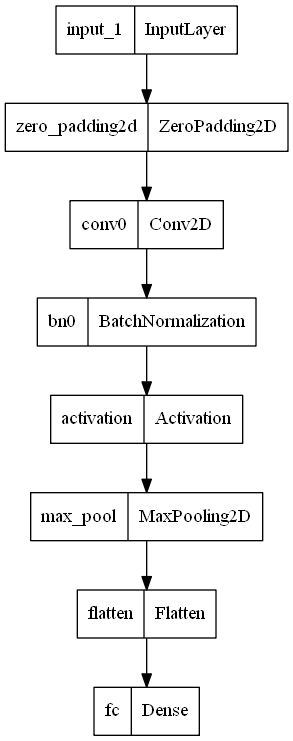

In [11]:
# plots the model in a nice layout and save it as ".png"
plot_model(facedetectionmodel, to_file='FaceDetectionModel.png')

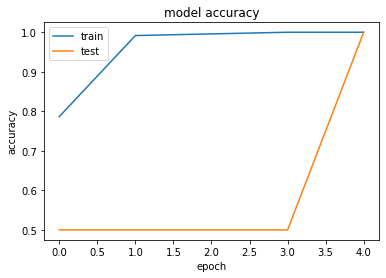

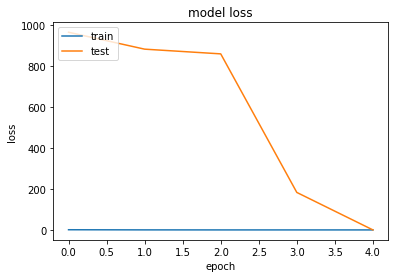

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
img_path = 'faces_test/.jpg'
img = image.load_img(img_path, target_size=(256, 256))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

if facedetectionmodel.predict(x)[0][0] == 0:
    print("picture with face(s)")
elif facedetectionmodel.predict(x)[0][0] == 1:
    print("picture without face(s)")  


FileNotFoundError: [Errno 2] No such file or directory: 'faces_test/.jpg'